<a href="https://colab.research.google.com/github/CheyQ27/Beijing-Housing/blob/main/Beijing_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price in Beijing
- Cheyenne Quann
- 06/15/2022

1) My source of data is https://www.kaggle.com/datasets/ruiqurm/lianjia and all data was fetched from https://bj.lianjia.com/chengjiao

2) This set contains extensive and pertinent information on the housing market in Beijing, China. This set is geared toward educating potential home buyers, and investment entities, containing information on price, home size, condition, community information and how long properties have been on the market.

3) My target will be the price of a home or the total price

4) This is a regression problem

5) There will be between 22 and 23 features

6) There are 200,000 rows in my dataset

7) The biggest challenge that I foresee is how I will split my data. I want to predict future housing prices so I need to figure out how to make my training set houses before a certain date and my testing set houses after that date

#Load Data and Imports

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/DataSets/200khouses.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,272244,https://bj.lianjia.com/chengjiao/BJSJ86937015....,BJSJ86937015,116.212671,39.900574,1.111027e+12,2014-01-01,NaN,5,450.0,...,3.0,未知,1,6,0.667,1.0,0.0,0.0,9,57942.0
1,183723,https://bj.lianjia.com/chengjiao/BJCY91181857....,BJCY91181857,116.445582,39.974979,1.111027e+12,2015-12-31,1.0,16,260.0,...,4.0,1998,3,6,0.333,0.0,1.0,1.0,7,66102.0
2,99668,https://bj.lianjia.com/chengjiao/BJCP85595070....,BJCP85595070,116.439420,40.072066,1.111027e+12,2015-03-24,1.0,13,237.0,...,4.0,2001,4,2,0.500,0.0,1.0,0.0,6,40934.0
3,181505,https://bj.lianjia.com/chengjiao/BJCY90950230....,BJCY90950230,116.481632,39.927935,1.111027e+12,2016-01-10,1.0,17,174.0,...,4.0,1987,3,6,0.167,1.0,1.0,1.0,7,67899.0
4,254148,https://bj.lianjia.com/chengjiao/BJHD88117786....,BJHD88117786,116.338384,39.934691,1.111027e+12,2014-11-24,1.0,3,280.0,...,4.0,1990,4,2,0.125,0.0,1.0,1.0,8,96480.0


In [ ]:
df.shape

(200000, 27)

In [ ]:
def evaluate_regression(model, X, y, index=[0]):


  preds = model.predict(X)
  scores = {'R2': r2_score(y, preds),
            'MAE': mean_absolute_error(y, preds),
            'MSE': mean_squared_error(y, preds),
            'RMSE': np.sqrt(mean_squared_error(y, preds))}
  scores = pd.DataFrame(scores, index=index)
  
  return scores

def try_regmodel(model, X_train, X_test, y_train, y_test, param_grid=None):
 

  if param_grid:
    model = GridSearchCV(model, param_grid)
  model.fit(X_train, y_train)

  train_scores = evaluate_regression(model, X_train, y_train, index=['Train'])
  test_scores = evaluate_regression(model, X_test, y_test, index=['Test'])

  scores = pd.concat([train_scores, test_scores], axis=0)
  return model, scores

In [ ]:
def explore_data(df):
  
  # Explore Columns
  print('Columns:')
  display(df.info())
  print('\n')

  # Find duplicates
  print(f'{df.duplicated().sum()} Duplicates Found \n')

  # Check for missing values
  print('Missing Values')
  display(df.isna().sum())
  print('\n')

  # Examine categories
  for col in df.select_dtypes(object).columns:
    print(col)
    display(df[col].value_counts())
    print('\n')

  # Show Summary Statistics
  display(df.describe(include='all'))
  

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['unnamed: 0', 'url', 'id', 'lng', 'lat', 'cid', 'tradetime', 'dom',
       'followers', 'totalprice', 'price', 'square', 'livingroom',
       'drawingroom', 'kitchen', 'bathroom', 'floor', 'buildingtype',
       'constructiontime', 'renovationcondition', 'buildingstructure',
       'ladderratio', 'elevator', 'fiveyearsproperty', 'subway', 'district',
       'communityaverage'],
      dtype='object')

# EDA And Cleaning

In [ ]:
explore_data(df)

Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   unnamed: 0           200000 non-null  int64  
 1   url                  200000 non-null  object 
 2   id                   200000 non-null  object 
 3   lng                  200000 non-null  float64
 4   lat                  200000 non-null  float64
 5   cid                  200000 non-null  float64
 6   tradetime            200000 non-null  object 
 7   dom                  100816 non-null  float64
 8   followers            200000 non-null  int64  
 9   totalprice           200000 non-null  float64
 10  price                200000 non-null  int64  
 11  square               200000 non-null  float64
 12  livingroom           200000 non-null  object 
 13  drawingroom          200000 non-null  object 
 14  kitchen              200000 non-null  int64  
 15  bathroom

None



0 Duplicates Found 

Missing Values


unnamed: 0                 0
url                        0
id                         0
lng                        0
lat                        0
cid                        0
tradetime                  0
dom                    99184
followers                  0
totalprice                 0
price                      0
square                     0
livingroom                 0
drawingroom                0
kitchen                    0
bathroom                   0
floor                      0
buildingtype            1277
constructiontime           0
renovationcondition        0
buildingstructure          0
ladderratio                0
elevator                  22
fiveyearsproperty         22
subway                    22
district                   0
communityaverage         278
dtype: int64



url


https://bj.lianjia.com/chengjiao/BJSJ86937015.html    1
https://bj.lianjia.com/chengjiao/BJCY84360856.html    1
https://bj.lianjia.com/chengjiao/BJCY84696021.html    1
https://bj.lianjia.com/chengjiao/BJCP88971686.html    1
https://bj.lianjia.com/chengjiao/BJHD84430590.html    1
                                                     ..
https://bj.lianjia.com/chengjiao/BJDX86739741.html    1
https://bj.lianjia.com/chengjiao/101100963168.html    1
https://bj.lianjia.com/chengjiao/BJCY91118544.html    1
https://bj.lianjia.com/chengjiao/BJHD84137543.html    1
https://bj.lianjia.com/chengjiao/BJXC84983361.html    1
Name: url, Length: 200000, dtype: int64



id


BJSJ86937015    1
BJCY84360856    1
BJCY84696021    1
BJCP88971686    1
BJHD84430590    1
               ..
BJDX86739741    1
101100963168    1
BJCY91118544    1
BJHD84137543    1
BJXC84983361    1
Name: id, Length: 200000, dtype: int64



tradetime


2016-02-28    677
2016-07-31    614
2016-03-06    579
2016-08-31    572
2016-03-05    534
             ... 
2011-01-26      1
2010-04-05      1
2010-12-22      1
2010-09-09      1
2011-09-02      1
Name: tradetime, Length: 2501, dtype: int64



livingroom


2         100582
1          51684
3          42498
4           4344
5            701
6            125
7             22
#NAME?        22
0             15
8              4
9              3
Name: livingroom, dtype: int64



drawingroom


1       141493
2        45634
0        12251
3          564
4           31
低 6          7
5            5
中 6          4
中 16         2
高 14         2
中 24         1
顶 6          1
低 15         1
底 20         1
低 16         1
中 14         1
底 11         1
Name: drawingroom, dtype: int64



bathroom


1       137059
2        27655
1        26860
2         5446
3         1726
0          473
3          306
4          261
0           88
4           54
5           31
5           11
6            6
2006         5
2004         4
2003         4
1990         2
2005         2
2000         2
未知           1
7            1
7            1
1994         1
2000         1
Name: bathroom, dtype: int64



floor


中 6     21681
顶 6     14297
高 6     13230
低 6      9898
底 6      8341
        ...  
低 35        1
低 63        1
低 36        1
低 37        1
低 5         1
Name: floor, Length: 201, dtype: int64



constructiontime


2004    13154
2003    12137
未知      12093
2005    11878
2006     9221
        ...  
1952        4
1968        4
1944        2
1961        1
1914        1
Name: constructiontime, Length: 71, dtype: int64

,unnamed: 0,url,id,lng,lat,cid,tradetime,dom,followers,totalprice,...,buildingtype,constructiontime,renovationcondition,buildingstructure,ladderratio,elevator,fiveyearsproperty,subway,district,communityaverage
count,200000.000000,200000,200000,200000.000000,200000.000000,2.000000e+05,200000,100816.000000,200000.000000,200000.000000,...,198723.000000,200000,200000.000000,200000.000000,2.000000e+05,199978.000000,199978.000000,199978.000000,200000.000000,199722.000000
unique,NaN,200000,200000,NaN,NaN,NaN,2501,NaN,NaN,NaN,...,NaN,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,https://bj.lianjia.com/chengjiao/BJSJ86937015....,BJSJ86937015,NaN,NaN,NaN,2016-02-28,NaN,NaN,NaN,...,NaN,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,1,NaN,NaN,NaN,677,NaN,NaN,NaN,...,NaN,13154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,159390.940465,NaN,NaN,116.418741,39.949671,1.123246e+12,NaN,28.936379,16.786265,349.473671,...,3.006926,NaN,2.607750,4.454635,5.042743e+01,0.578169,0.646411,0.601411,6.768835,63678.183505
std,91980.092832,NaN,NaN,0.112193,0.091854,1.192295e+12,NaN,50.561532,34.392438,229.575629,...,1.271434,NaN,1.311563,1.901186,2.238170e+04,0.493853,0.478085,0.489609,2.811960,22298.489601
min,0.000000,NaN,NaN,116.072514,39.627030,1.111027e+12,NaN,1.000000,0.000000,0.100000,...,0.048000,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,79810.750000,NaN,NaN,116.345084,39.893471,1.111027e+12,NaN,1.000000,0.000000,205.000000,...,1.000000,NaN,1.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46339.000000
50%,159374.500000,NaN,NaN,116.416780,39.934530,1.111027e+12,NaN,6.000000,5.000000,293.600000,...,4.000000,NaN,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59021.000000
75%,239184.250000,NaN,NaN,116.477730,40.003018,1.111027e+12,NaN,37.000000,18.000000,426.000000,...,4.000000,NaN,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75993.000000


- remove duplicates

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

remove unncessary columns


In [ ]:
df = df.drop(columns=['unnamed: 0','url','id','totalprice','constructiontime',
             'dom','followers','livingroom','drawingroom','kitchen','bathroom',
             'floor','ladderratio','elevator','fiveyearsproperty','subway','tradetime'])

- changed to an object dtype because the value is nominal and categorical 

In [ ]:
df['cid']=df['cid'].astype(object)

- examine unique values
- price will be a great target to predict

In [ ]:
df.nunique()

lng                     3868
lat                     3870
cid                     3907
price                  69301
square                 16781
buildingtype               9
renovationcondition        5
buildingstructure          7
district                  13
communityaverage        3959
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   lng                  200000 non-null  float64
 1   lat                  200000 non-null  float64
 2   cid                  200000 non-null  object 
 3   price                200000 non-null  int64  
 4   square               200000 non-null  float64
 5   buildingtype         198723 non-null  float64
 6   renovationcondition  200000 non-null  int64  
 7   buildingstructure    200000 non-null  int64  
 8   district             200000 non-null  int64  
 9   communityaverage     199722 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 16.8+ MB


- Checking the value count of my columns

In [ ]:
df['communityaverage'].value_counts()

92360.0     960
54263.0     952
50205.0     827
40934.0     820
64222.0     775
           ... 
41755.0       1
44785.0       1
40066.0       1
103070.0      1
116003.0      1
Name: communityaverage, Length: 3959, dtype: int64

In [ ]:
df['district'].value_counts()

7     67560
6     24087
8     24007
10    19558
2     18431
1     10659
4      9481
11     8760
9      7105
13     5844
5      1884
3      1549
12     1075
Name: district, dtype: int64

In [ ]:
df['buildingstructure'].value_counts()

6    118168
2     72445
4      8958
3       160
1       132
5       117
0        20
Name: buildingstructure, dtype: int64

In [ ]:
df['renovationcondition'].value_counts()

1    74390
4    73736
3    48504
2     3352
0       18
Name: renovationcondition, dtype: int64

In [ ]:
df['buildingtype'].value_counts()

4.000    108016
1.000     53249
3.000     37353
2.000        83
0.500        10
0.048         4
0.333         4
0.125         3
0.375         1
Name: buildingtype, dtype: int64

In [ ]:
df['square'].value_counts()

89.00     345
58.00     330
60.00     275
57.00     252
61.00     237
         ... 
137.19      1
291.96      1
34.62       1
185.06      1
212.73      1
Name: square, Length: 16781, dtype: int64

- this 3 value should in the next cell have been 30000


In [ ]:
df['price'].value_counts()

50000     126
40000      71
3          62
60000      58
100000     49
         ... 
75067       1
96147       1
79929       1
62106       1
87651       1
Name: price, Length: 69301, dtype: int64

In [ ]:
df['price'] = df['price'].replace('3', '30000')

In [ ]:
df['cid'].value_counts()

1.111027e+12    961
1.111027e+12    960
1.111027e+12    828
1.111027e+12    820
1.111027e+12    775
               ... 
1.111027e+12      1
1.111027e+12      1
1.111046e+12      1
1.111027e+12      1
1.111027e+12      1
Name: cid, Length: 3907, dtype: int64

In [ ]:
df['lat'].value_counts()

39.900529    961
39.919830    960
40.074228    828
40.072066    820
39.906426    775
            ... 
39.880653      1
39.926823      1
39.907219      1
40.093094      1
39.886165      1
Name: lat, Length: 3870, dtype: int64

In [ ]:
df['lng'].value_counts()

116.343245    961
116.609957    960
116.330198    828
116.439420    820
116.512916    796
             ... 
116.471372      1
116.251668      1
116.508402      1
116.477605      1
116.385460      1
Name: lng, Length: 3868, dtype: int64

- not too many missing, will impute in my preprocessor pipeline

In [ ]:
df.isna().sum()

lng                       0
lat                       0
cid                       0
price                     0
square                    0
buildingtype           1277
renovationcondition       0
buildingstructure         0
district                  0
communityaverage        278
dtype: int64

- no outliers to mention

In [ ]:
df.describe(include='all')

,lng,lat,cid,price,square,buildingtype,renovationcondition,buildingstructure,district,communityaverage
count,200000.000000,200000.000000,2.000000e+05,200000.00000,200000.000000,198723.000000,200000.000000,200000.000000,200000.000000,199722.000000
unique,NaN,NaN,3.907000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,1.111027e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,9.610000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,116.418741,39.949671,NaN,43535.37467,83.331072,3.006926,2.607750,4.454635,6.768835,63678.183505
std,0.112193,0.091854,NaN,21728.39398,37.115681,1.271434,1.311563,1.901186,2.811960,22298.489601
min,116.072514,39.627030,NaN,1.00000,6.900000,0.048000,0.000000,0.000000,1.000000,10847.000000
25%,116.345084,39.893471,NaN,28046.00000,57.940000,1.000000,1.000000,2.000000,6.000000,46339.000000
50%,116.416780,39.934530,NaN,38728.50000,74.300000,4.000000,3.000000,6.000000,7.000000,59021.000000
75%,116.477730,40.003018,NaN,53799.25000,98.830000,4.000000,4.000000,6.000000,8.000000,75993.000000


# Exploratory visualizations and Analysis

- My dataset's size means that I may need to use samples for a few of my visualizations
- Explored Distributions

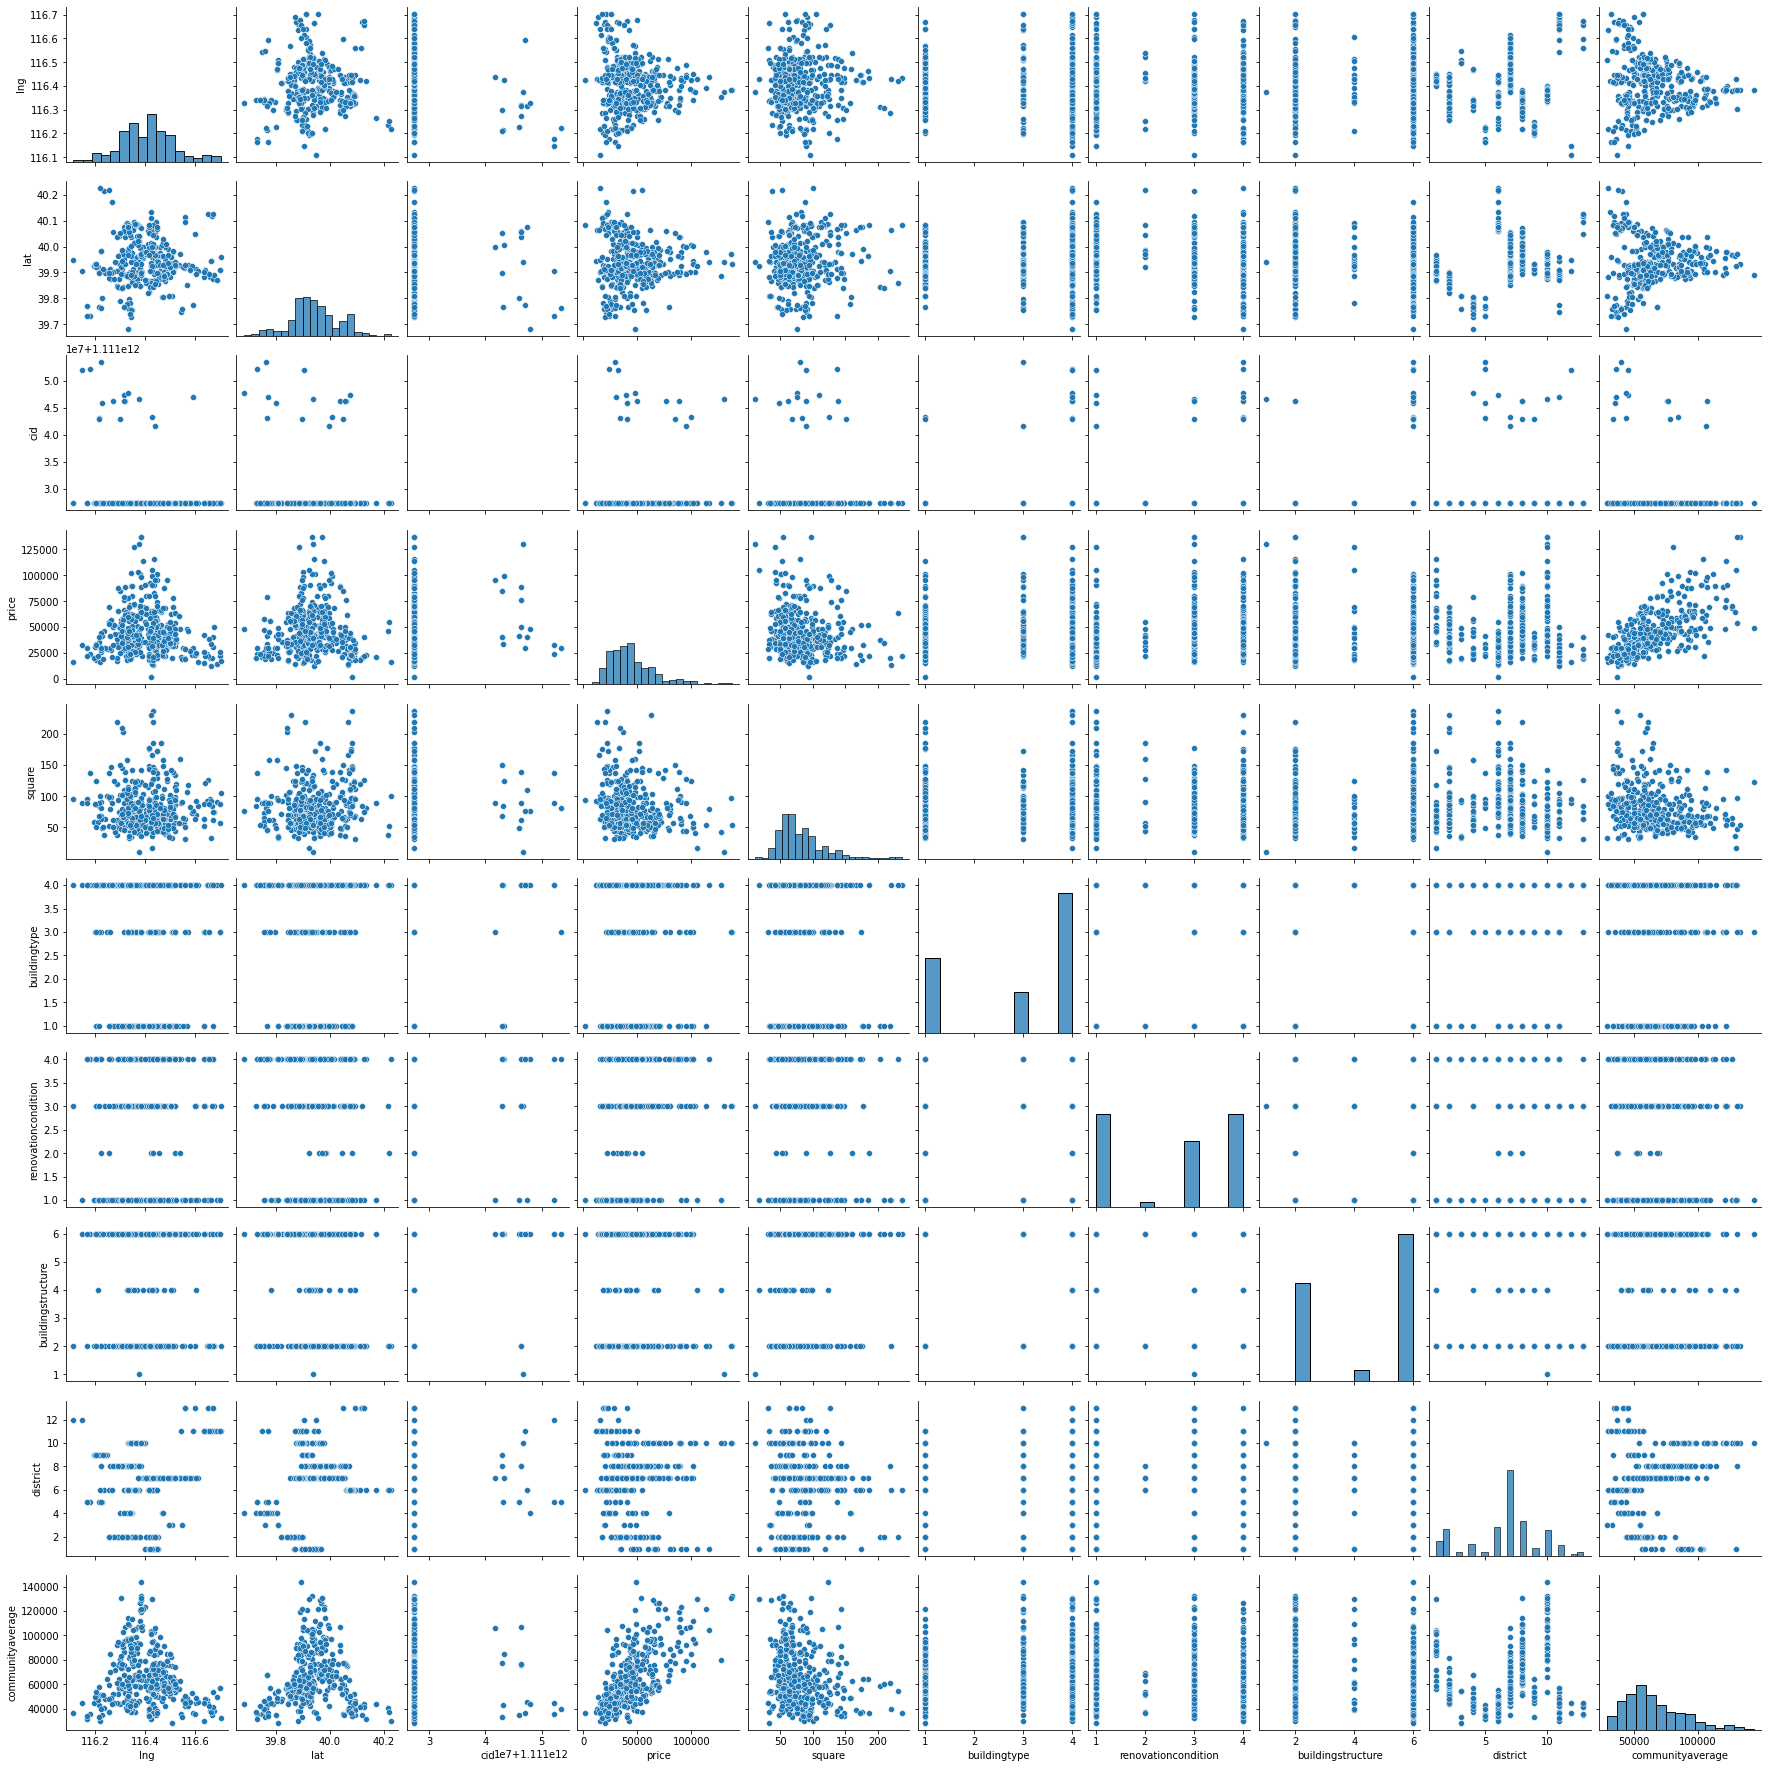

In [ ]:
sns.pairplot(df.sample(400))

- On first glance price and community average share a strong correlation and that will be explored
- Theres is also a moderate negative correlation betwween the building structure and the building type that may or may not be useful

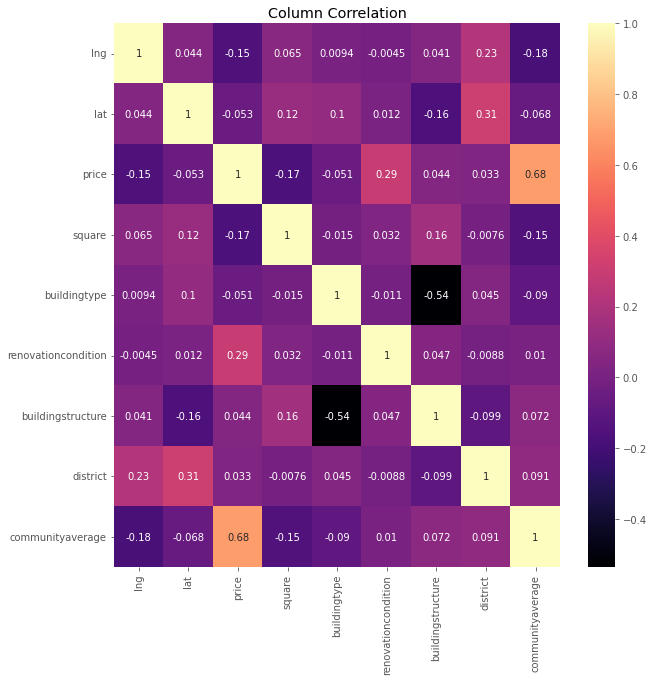

In [ ]:
corr = df.corr()
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap= 'magma', annot = True,);
plt.title('Column Correlation');

- As the the community average income increases we can see the property prices increase
- I think this scatter simplifies the relationship between price and community income for all the homes involved, most notibly the homes outside of the center mass.



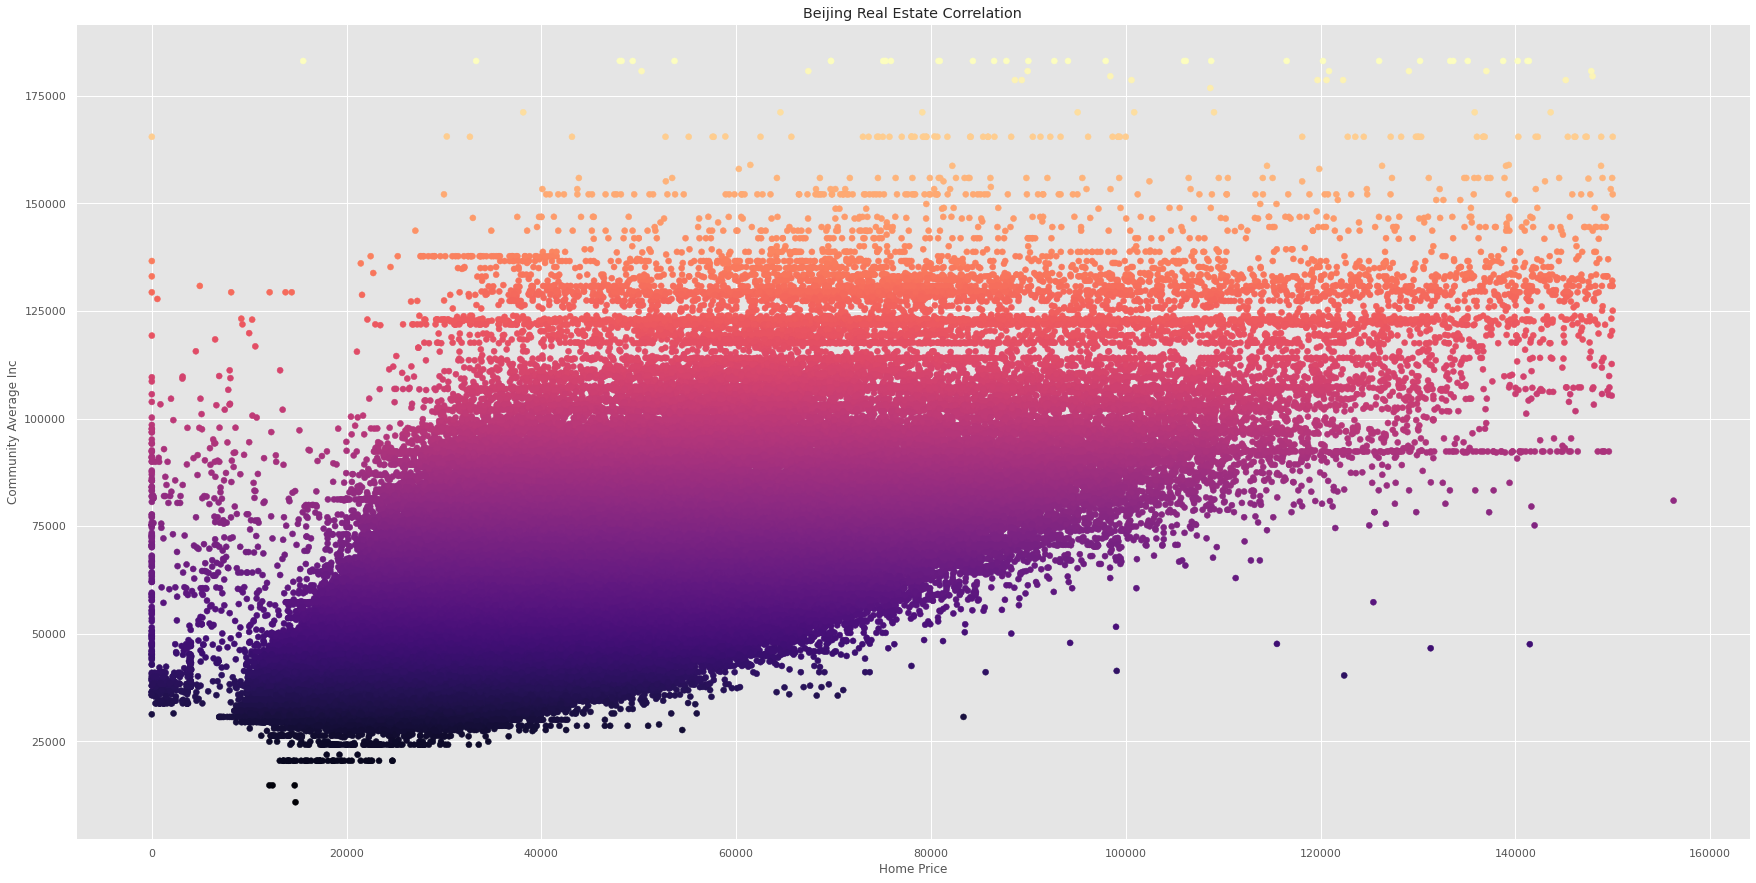

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(30,15))
plt.scatter(df['price'], df['communityaverage'], c=df['communityaverage'], cmap='magma');
plt.title('Beijing Real Estate Correlation')
plt.ylabel('Community Average Inc')
plt.xlabel('Home Price');

##Analysis of visuals
My plots show a map of the Beijing communities coloring each point by price of homes in the first plot and by the aver community income in the second plot.
My first observation was that of coure the maps are identical but the community average income plot differs from the price map plot in that toward the center of the plot there is a higher concentration of high incomes.
The closer one moves to 39.9 lat, 116.4 lng the more expensive the homes. Thus visualizing what my correlation plot plots have may clear. There is a strong positive correlation between the prices of the homes and the incomes of the people that live in those communities.

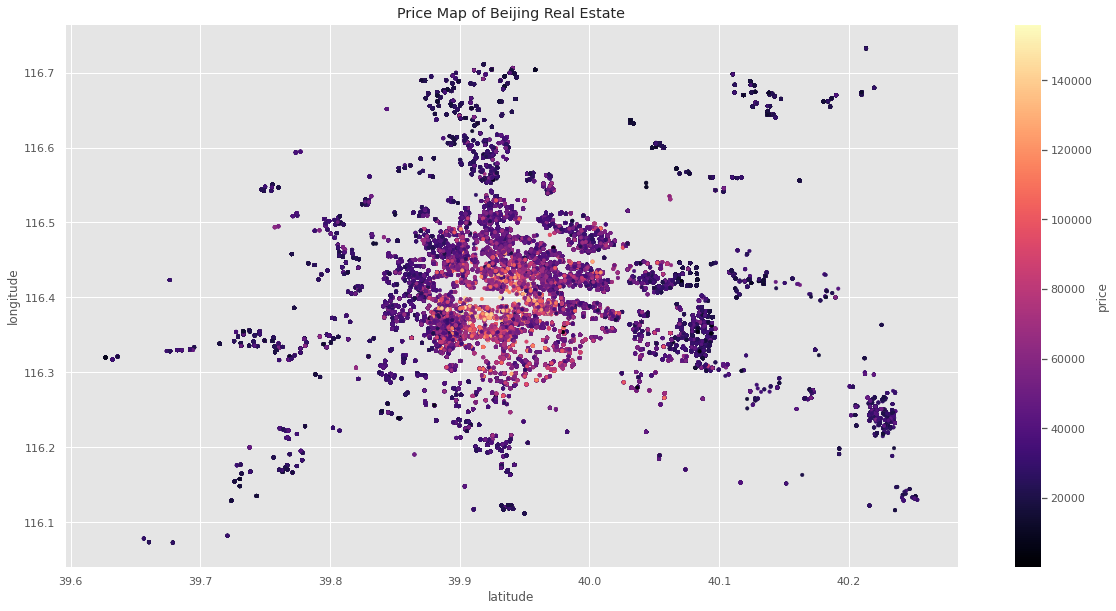

In [102]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.scatter(df['lat'], df['lng'], c=df['price'], cmap='magma', s=12);
plt.colorbar(label='price')
plt.title('Price Map of Beijing Real Estate')
plt.ylabel('longitude')
plt.xlabel('latitude')
plt.show();

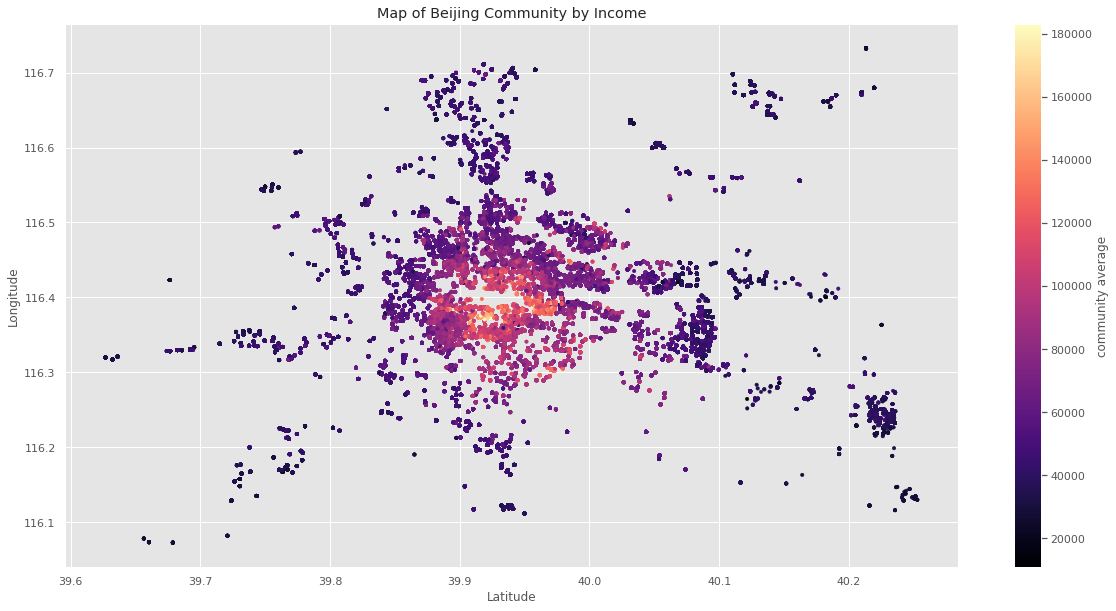

In [104]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.scatter(df['lat'], df['lng'], c=df['communityaverage'], cmap='magma', s=12);
plt.colorbar(label='community average')
plt.title('Map of Beijing Communities by Income')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show();

In [ ]:
df_sample = df.sample(10000)

- We will be predicting the price of homes that will come to the market in Beijing based on current community average incomes and home **prices** in our data 

In [ ]:
X = df_sample.drop(columns = 'price')
y = df_sample['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
num_sel = make_column_selector(dtype_include='number')
cat_sel = make_column_selector(dtype_include='object')

In [ ]:
cat_sel(X_train)

['cid']

In [ ]:
num_sel(X_train)

['lng',
 'lat',
 'square',
 'buildingtype',
 'renovationcondition',
 'buildingstructure',
 'district',
 'communityaverage']

In [ ]:
num_columns = num_sel(X_train)
cat_columns = cat_sel(X_train)

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
mean_imputer = SimpleImputer(strategy='mean')

In [ ]:
num_pipe = make_pipeline(mean_imputer,scaler)
cat_pipe = make_pipeline(ohe)
num_tuple = (num_pipe, num_sel)
cat_tuple = (cat_pipe, cat_sel)
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e190>)])

In [ ]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (7500, 2224)




array([[ 2.20050096,  1.85235969,  0.13260726, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51663627,  0.57964888,  0.35888721, ...,  0.        ,
         0.        ,  0.        ],
       [-0.50735857,  1.51778631, -0.78853959, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.02595801,  1.40546485,  1.72743272, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25772563, -0.67896716,  0.11006076, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82462689, -0.92592587,  0.53273976, ...,  0.        ,
         0.        ,  0.        ]])

#Model 1: Linear Regression

In [ ]:
lin_reg_pipe = make_pipeline(preprocessor, LinearRegression())
linreg_scores = try_regmodel(lin_reg_pipe, X_train, X_test, y_train, y_test)
linreg_scores

(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('pipeline-1',
                                                   Pipeline(steps=[('simpleimputer',
                                                                    SimpleImputer()),
                                                                   ('standardscaler',
                                                                    StandardScaler())]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                                  ('pipeline-2',
                                                   Pipeline(steps=[('onehotencoder',
                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                  sparse=False)

In [ ]:
lasso_pipe = make_pipeline(preprocessor, Lasso())
lasso_params = {'lasso__alpha': [100, 1000, 10000]}
lasso, lasso_scores = try_regmodel(lasso_pipe, X_train, X_test, y_train, y_test,  param_grid=lasso_params)                                  
display(lasso_scores)
lasso.best_estimator_.get_params()['lasso']

,R2,MAE,MSE,RMSE
Train,0.561204,10927.570714,2.082370e+08,14430.418551
Test,0.562186,10865.803492,2.109552e+08,14524.296685


Lasso(alpha=100)

In [ ]:
ridge_pipe = make_pipeline(preprocessor, Ridge())
ridge_params = {'ridge__alpha': [.01, .1, 1, 10, 100]}
ridge, ridge_scores = try_regmodel(ridge_pipe, X_train, X_test, y_train, y_test,param_grid=ridge_params)
display(ridge_scores)
ridge.best_estimator_.get_params()['ridge']

,R2,MAE,MSE,RMSE
Train,0.624273,10129.011671,1.783068e+08,13353.158513
Test,0.562382,10857.896862,2.108610e+08,14521.053225


Ridge(alpha=10)

#Model 2: Decision Tree Regressor

In [ ]:
def eval_regression(true, pred):
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)
  print(f'\n RMSE: {rmse},\n R^2: {r2} ')

In [ ]:
dec_tree_pipe = make_pipeline(preprocessor, DecisionTreeRegressor())

In [ ]:
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e190>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [ ]:
print('Train Evaluation')
eval_regression(y_train, dec_tree_pipe.predict(X_train))
print('Test Evaluation')
eval_regression(y_test, dec_tree_pipe.predict(X_test))

Train Evaluation

 RMSE: 1651.943212703014,
 R^2: 0.9942496378243597 
Test Evaluation

 RMSE: 19151.82833690588,
 R^2: 0.23876331211753565 


In [ ]:
dec_tree_pipe = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth = 8, random_state = 42))

In [ ]:
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e190>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=8, random_state=42))])

In [ ]:
print('Train Evaluation')
eval_regression(y_train, dec_tree_pipe.predict(X_train))
print('Test Evaluation')
eval_regression(y_test, dec_tree_pipe.predict(X_test))

Train Evaluation

 RMSE: 12822.09278874193,
 R^2: 0.6535641705541779 
Test Evaluation

 RMSE: 14957.065292816478,
 R^2: 0.5357071355059674 


In [ ]:
dec_tree_pipe = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth = 5, random_state = 42))

In [ ]:
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e190>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [ ]:
print('Train Evaluation')
eval_regression(y_train, dec_tree_pipe.predict(X_train))
print('Test Evaluation')
eval_regression(y_test, dec_tree_pipe.predict(X_test))

Train Evaluation

 RMSE: 13657.732245841273,
 R^2: 0.6069370044963363 
Test Evaluation

 RMSE: 14631.007513114688,
 R^2: 0.5557292746781265 


- I want to maintain remove 2 components and see if get better metrics

In [ ]:
scaler = StandardScaler()
pca = PCA(n_components = .95)
preprocessor2 = make_pipeline(scaler, pca)

In [ ]:
print('before pca', X_train.shape)
print('after pca', preprocessor2.fit_transform(X_train_processed).shape)
print('columns reduced by:', X_train.shape[1] - preprocessor2.fit_transform(X_train_processed).shape[1])

before pca (7500, 9)
after pca (7500, 2105)
columns reduced by: -2096


In [ ]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
dec_tree_pca_pipe = make_pipeline(preprocessor, pca, DecisionTreeRegressor(max_depth = 5, random_state = 42))
dec_tree_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7e0b1e190>)])),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [ ]:
print('Train Evaluation')
eval_regression(y_train, dec_tree_pca_pipe.predict(X_train))
print('Test Evaluation')
eval_regression(y_test, dec_tree_pca_pipe.predict(X_test))

Train Evaluation

 RMSE: 15238.539141267298,
 R^2: 0.5106814943631144 
Test Evaluation

 RMSE: 16113.065382498324,
 R^2: 0.4611652836457467 


During this modeling process, I noticed that my Linear regression model gave me the least amount of issues from dealing with the large set to following my functions.
I had to create a separate one to evaluate my 2nd model. The results were a bit underfit compared to the Linear Regression model. I'm choosing my 1st model as the production and final model because I was able to get the best metrics on my Linear Regression (lasso) model.
The accuracy and RMSE scores are almost identical and by using this model the client will be able to predict the next home's price within 14,500 dollars. The R2 score was below 60% both ways which point to some underfitting. This model could have several practical uses depending on how it is modified. The current code and model would be most useful to a real estate agency or residential home investor looking to gauge where the most expensive listing will be and expand their holdings.